In [1]:
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import csv
import os
import datetime
import pandas as pd
import shapefile as shp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely as shp
from shapely.geometry import Point
import importlib
import geopandas as gpd
from matplotlib.patches import Rectangle
from collections import Counter
import time
import _pickle as pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#import external functions written in HaileventsFunctions.ipynb (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# 1) - DATA PRE-PROCESSING
Read and pre-process data for ESWD reports, SPHERA reanalysis, OT satellite detections

## 1.0) - Preamble: load data folder, shapefiles, lat-lon domain

In [2]:
#Define preliminar parameters: files folder, shapefiles, lat-lon domain
fold, sf_geo, sfg_land, sf_sp, lonmin, lonmax, latmin, latmax, x_lim, y_lim, hhmin, hhmax = HF.HF_preamble()

## 1.1) - Read ESWD data

Considered are only events having quality control >QC0+ (i.e. QC0+: reports that passed a basic plausibility check, QC1 reports is confirmed by a reliable source, QC2 reports based on detailed case studies on a scientific level (very rare)).

In [3]:
#Read ESWD data:
df_eswd_1 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')
df_eswd_2 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_20200601-20201031_v1_6.csv')

In [4]:
#Select data of interest
eswd_df_1 = pd.DataFrame()
eswd_df_1['datetime'] = pd.to_datetime(df_eswd_1['TIME_EVENT'])
eswd_df_1[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_1[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_1 = eswd_df_1.sort_values(by='datetime').reset_index(drop=True)

#remove June 2020 data because they are already present in df_eswd_2
eswd_df_1 = eswd_df_1.drop(eswd_df_1[(eswd_df_1.datetime.dt.year==2020)&(eswd_df_1.datetime.dt.month==6)].index)

eswd_df_2 = pd.DataFrame()
eswd_df_2['datetime'] = pd.to_datetime(df_eswd_2['TIME_EVENT'])
eswd_df_2[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_2[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_2 = eswd_df_2.sort_values(by='datetime').reset_index(drop=True)

#concat the two datasets:
eswd_df = pd.concat([eswd_df_1,eswd_df_2])

#Retain only reports in the selected period and space domain
eswd_df_years = eswd_df.datetime.apply(lambda x: x.year)
eswd_df_months = eswd_df.datetime.apply(lambda x: x.month)
eswd_df_days = eswd_df.datetime.apply(lambda x: x.day)
eswd_df_hours = eswd_df.datetime.apply(lambda x: x.hour)

eswd_df_sel = eswd_df.loc[(eswd_df_years >= 2016) & (eswd_df_years <= 2020) & (eswd_df_months >= 4)   #(eswd_df_years >= 1995) &
                         & (eswd_df_months <= 10)]
eswd_df_sel = eswd_df_sel.loc[(eswd_df_sel.lat >= latmin) & (eswd_df_sel.lat <= latmax)]
eswd_ev_sel = eswd_df_sel.loc[(eswd_df_sel.lon >= lonmin) & (eswd_df_sel.lon <= lonmax)].reset_index(drop=True)

#Convert to geodataframe:
eswd = gpd.GeoDataFrame(eswd_ev_sel, geometry=gpd.points_from_xy(eswd_ev_sel.lon, eswd_ev_sel.lat))

In [5]:
#remove data too close to sphera border/upper-right corner of the domain (2016-2018):
tbRemoved = [128,316,327,328,330,
             507,632,883,884,
             929,
            1676,1678,
            2229,2232]
eswd = eswd.drop(tbRemoved)

In [6]:
#Remove ESWD data when SPHERA data is missing
dates2020_tbRemoved = pd.Series(['2020-06-22','2020-06-23','2020-06-24','2020-06-25','2020-07-14','2020-07-15',
                                 '2020-07-18','2020-07-23','2020-07-24','2020-07-25','2020-07-31','2020-08-01',
                                 '2020-08-02','2020-08-03','2020-08-04','2020-08-05','2020-08-06','2020-08-07',
                                 '2020-08-15'])
eswd_2020_tbRemoved_JJA = eswd[eswd.datetime.dt.strftime('%Y-%m-%d').isin(dates2020_tbRemoved)]

In [7]:
#split eswd dataset in the years:
eswd_2016 = eswd[eswd.datetime.dt.year ==2016]
eswd_2017 = eswd[eswd.datetime.dt.year ==2017].reset_index(drop=True)
eswd_2018 = eswd[eswd.datetime.dt.year ==2018].reset_index(drop=True)
eswd_2019 = eswd[eswd.datetime.dt.year ==2019].reset_index(drop=True)
eswd_2020 = eswd[eswd.datetime.dt.year ==2020].reset_index(drop=True)

#divide eswd dataset in datasets with info on size of hail or not:
eswd_NOsize = eswd.loc[np.isnan(eswd['size']) == True].reset_index(drop=True)
eswd_wsize = eswd.loc[np.isnan(eswd['size']) == False].reset_index(drop=True)
eswd_small = eswd_wsize[eswd_wsize['size'] < 3]
eswd_large = eswd_wsize[eswd_wsize['size'] >= 3]
eswd_Verylarge = eswd_wsize[eswd_wsize['size'] >= 5]

### 1.1.1) - ESWD data characterization

- Spatial distribution

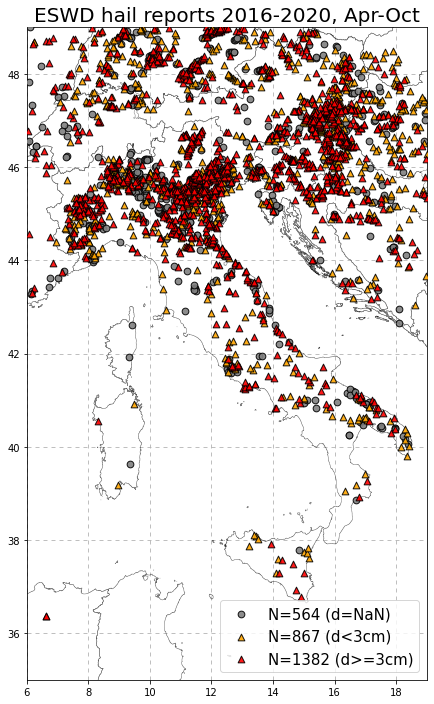

In [8]:
fig, ax = plt.subplots(figsize = (10,12))

plt.xlim(x_lim)
plt.ylim(y_lim)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)
    
'''
PLOT ESWD data 
'''

c3_1=pl.scatter(eswd_NOsize.lon,eswd_NOsize.lat,45,c='grey',
                marker="o",edgecolor='k',alpha=0.9,zorder=4, label='N=564 (d=NaN)')
c3_2=pl.scatter(eswd_small.lon,eswd_small.lat,45,
                c='orange',marker="^", edgecolor='k',alpha=0.9,zorder=4, label='N=867 (d<3cm)')
c3_2=pl.scatter(eswd_large.lon,eswd_large.lat,45,
                c='red',marker="^", edgecolor='k',alpha=0.9,zorder=4, label='N=1382 (d>=3cm)')

pl.legend(loc='best', fontsize=15)
pl.grid(ls=(0,(5,5)))
pl.title('ESWD hail reports 2016-2020, Apr-Oct', fontsize=20);

- Hail stone size distribution

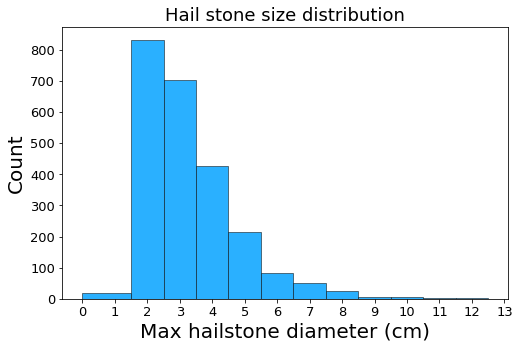

In [9]:
eswd_wSize = eswd_ev_sel.loc[eswd_ev_sel['size'].isnull() != True].reset_index(drop=True)

#Histogram of hail stone size distribution in ESWD events:
plt.figure(figsize=(8,5)) 

plt.hist(eswd_wSize['size'], bins=[0,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5],
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5)
pl.locator_params(axis='x', nbins=15)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Max hailstone diameter (cm)', fontsize=20)
plt.title('Hail stone size distribution', fontsize=18);
plt.tick_params(axis='both', which='major', labelsize=13)

- Hourly distribution

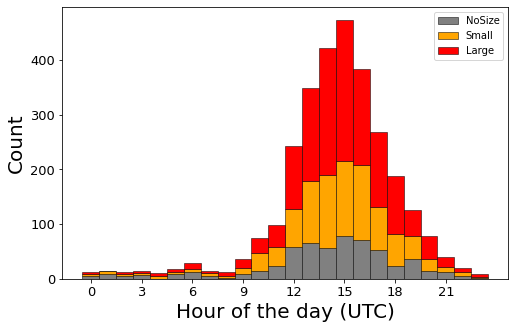

In [12]:
#Histogram of hailstorm distribution dep. on the hour of the day in ESWD events: 
#SEPARATING DIFFERENT HAIL SIZES
plt.figure(figsize=(8,5)) 

plt.hist([eswd_NOsize['datetime'].dt.hour,
          eswd_small['datetime'].dt.hour, 
          eswd_large['datetime'].dt.hour], 
         edgecolor='black', linewidth=0.5,
         bins=np.arange(25)-0.5, density=False, stacked=True, label=['NoSize', 'Small', 'Large'],
        color=['grey','orange','red'])

pl.locator_params(axis='x', nbins=24)
plt.xticks(np.arange(0, 24, 3))

plt.ylabel('Count', fontsize=20)
plt.xlabel('Hour of the day (UTC)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend();

- Latitudinal distribution

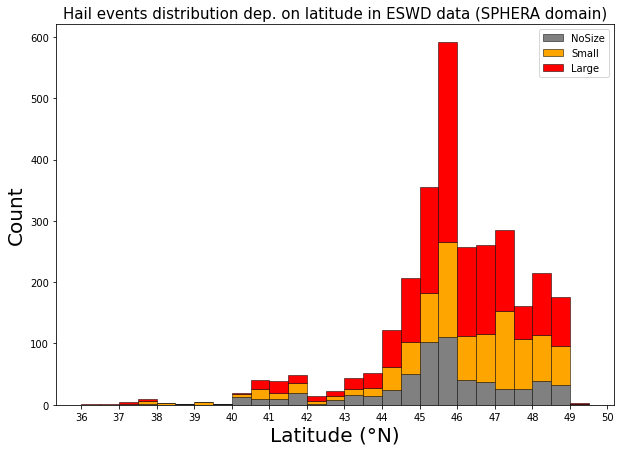

In [13]:
#Histogram of hailstorm distribution dep. latitude in ESWD events:
#SEPARATING DIFFERENT HAIL SIZES

plt.figure(figsize=(10,7)) 

plt.hist([eswd_NOsize['lat'],
          eswd_small['lat'], 
          eswd_large['lat']], 
         edgecolor='black', linewidth=0.5,
         bins=np.arange(36,50,.5), density=False, stacked=True, label=['NoSize', 'Small', 'Large'],
        color=['grey','orange','red'])

pl.locator_params(axis='x', nbins=24)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Latitude (°N)', fontsize=20)
plt.title('Hail events distribution dep. on latitude in ESWD data (SPHERA domain)', fontsize=15);
plt.legend();

- Monthly distribution

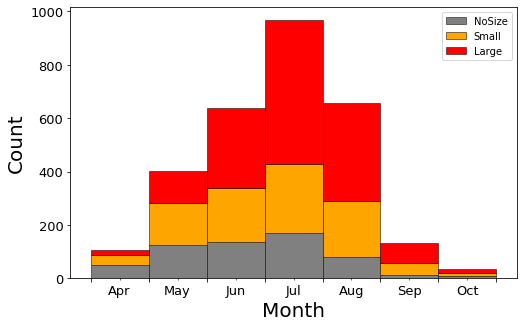

In [14]:
#Histogram of hailstorm distribution dep. MONTH in ESWD events:
#SEPARATING DIFFERENT HAIL SIZES

fig, ax = plt.subplots(figsize = (8,5))

plt.hist([eswd_NOsize['datetime'].dt.month,
          eswd_small['datetime'].dt.month, 
          eswd_large['datetime'].dt.month], 
         edgecolor='black', linewidth=0.5,
         bins=np.arange(4,12,1), density=False, stacked=True, label=['NoSize', 'Small', 'Large'],
        color=['grey','orange','red'])

pl.locator_params(axis='x', nbins=8)


ax.set_xticklabels('')
ax.set_xticks([4.5,5.5,6.5,7.5,8.5,9.5,10.5],      minor=True)
ax.set_xticklabels(['Apr','May','Jun','Jul','Aug','Sep','Oct'], minor=True, fontsize=12)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)
plt.legend();

- Annual distribution

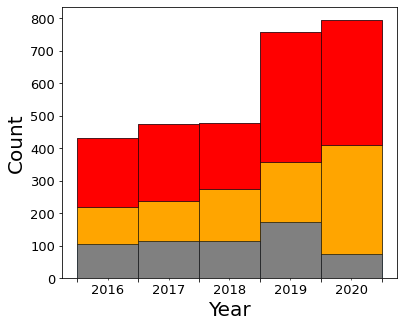

In [15]:
#Histogram of hailstorm distribution dep. YEARS in ESWD events:
fig, ax = plt.subplots(figsize = (6,5))

plt.hist(eswd.datetime.dt.year, bins=[2016,2017,2018,2019,2020,2021],
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5)

plt.hist([eswd_NOsize['datetime'].dt.year,
          eswd_small['datetime'].dt.year, 
          eswd_large['datetime'].dt.year], 
         edgecolor='black', linewidth=0.5,
         bins=[2016,2017,2018,2019,2020,2021], density=False, stacked=True, label=['NoSize', 'Small', 'Large'],
        color=['grey','orange','red'])

pl.locator_params(axis='x', nbins=8)


ax.set_xticklabels('')
ax.set_xticks([2016.5,2017.5,2018.5,2019.5,2020.5], minor=True)
ax.set_xticklabels(['2016','2017','2018','2019','2020'], minor=True, fontsize=15)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

- Reports temporal accuracy distribution

In [16]:
#count occurrences of different temporal accuracies in hail reports
eswd_NOsize_counter = Counter(eswd_NOsize['Time_accuracy'].loc[eswd_NOsize['Time_accuracy'].isnull() 
                                                               != True].reset_index(drop=True))
eswd_small_counter = Counter(eswd_small['Time_accuracy'].loc[eswd_small['Time_accuracy'].isnull() 
                                                               != True].reset_index(drop=True))
eswd_large_counter = Counter(eswd_large['Time_accuracy'].loc[eswd_large['Time_accuracy'].isnull() 
                                                               != True].reset_index(drop=True))

time_arr_class_NOsize = [eswd_NOsize_counter['5M'], eswd_NOsize_counter['15M'], eswd_NOsize_counter['30M'],
            eswd_NOsize_counter['1H'], eswd_NOsize_counter['3H'], eswd_NOsize_counter['6H'],
            eswd_NOsize_counter['12H']]
time_arr_class_small = [eswd_small_counter['5M'], eswd_small_counter['15M'], eswd_small_counter['30M'],
            eswd_small_counter['1H'], eswd_small_counter['3H'], eswd_small_counter['6H'],
            eswd_small_counter['12H']]
time_arr_class_large = [eswd_large_counter['5M'], eswd_large_counter['15M'], eswd_large_counter['30M'],
            eswd_large_counter['1H'], eswd_large_counter['3H'], eswd_large_counter['6H'],
            eswd_large_counter['12H']]

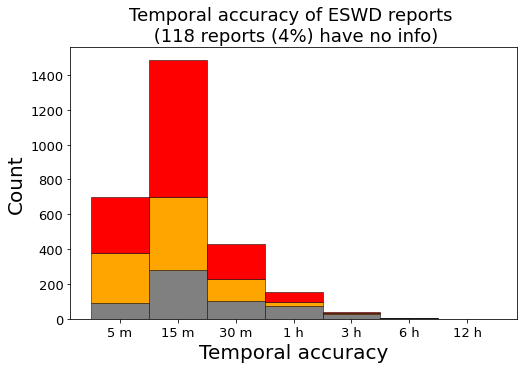

In [17]:
fig, ax = plt.subplots(figsize = (8,5))
#Histogram of hail stone size distribution in ESWD events:

plt.bar(['5 m','15 m','30 m','1 h','3 h','6 h','12 h'], time_arr_class_NOsize, 
        facecolor = 'grey', edgecolor='black', linewidth=0.5, width=1)
plt.bar(['5 m','15 m','30 m','1 h','3 h','6 h','12 h'], time_arr_class_small, bottom=time_arr_class_NOsize,
        facecolor = 'orange', edgecolor='black', linewidth=0.5, width=1)
plt.bar(['5 m','15 m','30 m','1 h','3 h','6 h','12 h'], time_arr_class_large, 
        bottom=list(np.add(time_arr_class_NOsize,time_arr_class_small)),
        facecolor = 'red', edgecolor='black', linewidth=0.5, width=1)

#pl.locator_params(axis='x', nbins=8)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Temporal accuracy', fontsize=20)
plt.title('Temporal accuracy of ESWD reports \n (118 reports (4%) have no info)', fontsize=18);
plt.tick_params(axis='both', which='major', labelsize=13)

- **Hail layer Thickness** info: only 159 out of 2275 hail reports have info on layer thickness of the accumulated hail on the ground

In [18]:
eswd_HThickness = eswd[eswd['Thickness_hail_layer'].isnull() == False]

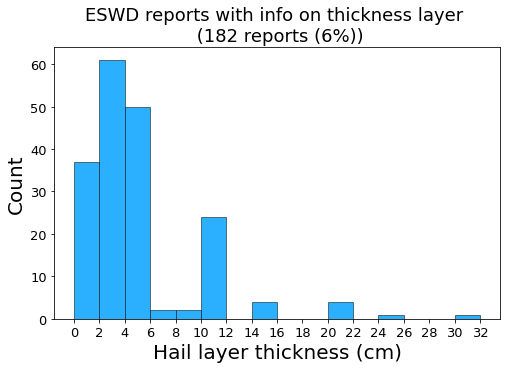

In [19]:
#Histogram of hail stone size distribution in ESWD events:
plt.figure(figsize=(8,5)) 

plt.hist(eswd_HThickness['Thickness_hail_layer'], bins=np.arange(0,34,2),
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5)
pl.locator_params(axis='x', nbins=20)

plt.ylabel('Count', fontsize=20)
plt.xlabel('Hail layer thickness (cm)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('ESWD reports with info on thickness layer \n (182 reports (6%))', fontsize=18);

## 1.2) - Read SPHERA reanalysis data

### 1.2.1) - Identify missing/problematic data:

- Missing SPHERA data 
- ESWD reports too close to SPHERA upper-right grid border

### 1.2.2) - Read SPHERA data and extract only days when ESWD reports are present
<span style="color:red"> This is commented because it needs to be done only one time to read and write external dictionaries </span>

#2016
#dictionary to contain dataframes of daily SPHERA data only considering ESWD days:
sp_eswd_2016 = dict()

for eswd_day in eswd_2016.datetime.dt.date.unique():
    print(eswd_day)
    sp_eswd_2016[eswd_day] = HF.HF_reanProxies_read(eswd_day)

#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2016.txt', 'wb') as file:
     pickle.dump(sp_eswd1,file) # use `json.loads` to do the reverse

#2017
#dictionary to contain dataframes of daily SPHERA data only considering ESWD days:
sp_eswd_2017 = dict()

for eswd_day in eswd_2017.datetime.dt.date.unique():
    print(eswd_day)
    sp_eswd_2017[eswd_day] = HF.HF_reanProxies_read(eswd_day.year, eswd_day.month, eswd_day.day)

#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2017.txt', 'wb') as file:
     pickle.dump(sp_eswd2,file)

#2018
#dictionary to contain dataframes of daily SPHERA data only considering ESWD days:
sp_eswd_2018 = dict()

for eswd_day in eswd_2018.datetime.dt.date.unique():
    print(eswd_day)
    sp_eswd_2018[eswd_day] = HF.HF_reanProxies_read(eswd_day.year, eswd_day.month, eswd_day.day)

#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2018.txt', 'wb') as file:
     pickle.dump(sp_eswd_2018,file)

#2019
#dictionary to contain dataframes of daily SPHERA data only considering ESWD days:
sp_eswd_2019 = dict()

for eswd_day in eswd_2019.datetime.dt.date.unique():
    print(eswd_day)
    sp_eswd_2019[eswd_day] = HF.HF_reanProxies_read(eswd_day)

#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2019.txt', 'wb') as file:
     pickle.dump(sp_eswd_2019,file)

#2020
#dictionary to contain dataframes of daily SPHERA data only considering ESWD days:
sp_eswd_2020 = dict()

for eswd_day in eswd_2020.datetime.dt.date.unique()[:]:
    print(eswd_day)
    sp_eswd_2020[eswd_day] = HF.HF_reanProxies_read(eswd_day)

#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2020.txt', 'wb') as file:
     pickle.dump(sp_eswd_2020,file)

In [8]:
#read dictionaries from external file
"""
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2016.txt', "rb") as file:  
     sp_eswd_2016 = pickle.load(file)

with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2017.txt', "rb") as file:  
     sp_eswd_2017 = pickle.load(file)

with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2018.txt', "rb") as file:  
     sp_eswd_2018 = pickle.load(file)

with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2019.txt', "rb") as file:  
     sp_eswd_2019 = pickle.load(file)
"""     
with open(fold + 'data/SPHERA/sphera_indices_grid10km/SpInd_eswdDays_2020.txt', "rb") as file:  
     sp_eswd_2020 = pickle.load(file)

### 1.2.3) - Select SPHERA data in a spatio-temporal window of 3h and 70km around each ESWD report to build CDF and define OT-filter thresholds
**Attention:** if ESWD reports are issued after 23.30 UTC of the day possible problem, see below (as in 2018 cases) 

In [9]:
"""
SELECT THE YEAR
"""
year=2020

In [ ]:
"""
1st step: 3-h temporal extraction
"""
#dictionary to contain SPHERA geodataframes of 3h aggregations around every hour of ESWD events:
dgdf_sp_3ESWDh = dict()

if year == 2016:
    gdf_eswd = eswd_2016
    sp_eswd = sp_eswd_2016

if year == 2017:
    gdf_eswd = eswd_2017
    sp_eswd = sp_eswd_2017

if year == 2018:
    gdf_eswd = eswd_2018
    sp_eswd = sp_eswd_2018
    
if year == 2019:
    gdf_eswd = eswd_2019
    sp_eswd = sp_eswd_2019
    
if year == 2020:
    gdf_eswd = eswd_2020
    sp_eswd = sp_eswd_2020

for ind in gdf_eswd.index:
    
    print(ind)
    
    #2016
    if year == 2016:
        #condition for the missing day of sphera data (20/7/2016)
        if gdf_eswd.loc[ind].datetime.date() == datetime.date(2016, 7, 20):
            dgdf_sp_3ESWDh[ind] = gpd.GeoDataFrame()
            continue
    
    #2018
    #if year == 2018:
    #condition for the 2018 cases with eswd hour >= 23.30 utc ( 2018-06-04 23:40:00 and 2018-06-04 23:44:00):
    #    if (ind == 183) or (ind == 184):

    #2019
    if year == 2019:
        #condition for the 2019 cases with eswd hour >= 23.30 utc (2019-07-01 23:40:00):
        if ind==314:
            print('Exception: hh>23:30')
            gdf_eswd_1rep = gdf_eswd.loc[ind]
            
            #select dataframe of SPHERA with the same day of the eswd event (and of the day before if needed):
            df_sp_eswd =  sp_eswd[gdf_eswd_1rep.datetime.date()+ timedelta(days=1)]

            df_sp_eswd_Dbefore = sp_eswd[gdf_eswd_1rep.datetime.date()]

            #find timing of ESWD occurrence (round to hour every 30 mins)
            eswd_hour = (gdf_eswd_1rep.datetime.replace(second=0, microsecond=0, minute=0, hour=gdf_eswd_1rep.datetime.hour) 
                         +timedelta(hours=gdf_eswd_1rep.datetime.minute//30)).hour

            #condition if all the 3hours fall within the OT day of the event:
            if eswd_hour >= 2:

                #select the last 3 hours from SPHERA daily dataset
                df_sp_3ESWDh = df_sp_eswd.loc[(df_sp_eswd.datetime.dt.hour > (int(eswd_hour) - 3)) & 
                                              (df_sp_eswd.datetime.dt.hour <= int(eswd_hour))].reset_index(drop=True)

            #condition if the 3hours are straddling 2 days:
            elif eswd_hour <=1:
                df_sp_3ESWDh = df_sp_eswd.loc[(df_sp_eswd.datetime.dt.hour > (int(eswd_hour) - 3)) & 
                                       (df_sp_eswd.datetime.dt.hour <= int(eswd_hour))].reset_index(drop=True)

                df_sp_3ESWDh_Dbefore = df_sp_eswd_Dbefore.loc[(df_sp_eswd_Dbefore.datetime.dt.hour 
                                                               >= 22+eswd_hour)].reset_index(drop=True)

                df_sp_3ESWDh = pd.concat([df_sp_3ESWDh_Dbefore, df_sp_3ESWDh]).reset_index(drop=True)

            #build sphera geodataframe containing temporal aggregation over the last 3 hours (max/min depending on param):
            gdf_sp_3ESWDh = gpd.GeoDataFrame(columns=['datetime_agg','box_id','%VV700','Kindex','LI','DLS','H0',
                                                   'CAPE_MU','CAPE_ML','geometry'])

            gdf_sp_3ESWDh['box_id'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['box_id']
            gdf_sp_3ESWDh['datetime_agg'][:] = df_sp_3ESWDh["datetime"].iloc[-1]  #referring to last hour of aggregation
            gdf_sp_3ESWDh['%VV700'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['%VV700']
            gdf_sp_3ESWDh['Kindex'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['Kindex']
            gdf_sp_3ESWDh['LI'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).min()['LI']
            gdf_sp_3ESWDh['DLS'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['DLS']
            gdf_sp_3ESWDh['H0'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).min()['H0']
            gdf_sp_3ESWDh['CAPE_MU'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['CAPE_MU']
            gdf_sp_3ESWDh['CAPE_ML'] = df_sp_3ESWDh.groupby(['box_id'], as_index=False).max()['CAPE_ML']
            gdf_sp_3ESWDh['geometry'] = sf_sp.loc[sf_sp.index[list(gdf_sp_3ESWDh['box_id'])]].reset_index(drop=True)['geometry']

            dgdf_sp_3ESWDh[ind] = gdf_sp_3ESWDh

            continue
    
    #in the rest of the cases use external function to compute!
    dgdf_sp_3ESWDh[ind] = HF.HF_rean_tAgg_ESWDh(gdf_eswd.loc[ind], sp_eswd, sf_sp)

In [ ]:
"""
2nd step: spatial extraction on the neighborhood in the 70km around each report
"""
#dictionary to contain SPHERA geodataframes of 3h aggregations and spatial neighbourhood limited
#around every ESWD event:
dgdf_sp_3ESWDh_nn = dict()

for ind in gdf_eswd.index:
    print(ind)
    
    #conditions for the missing day of sphera data (20/7/2016) and for eswd reports too close to sphera border:
     
    #2016: 
    #if (ind == 316) or (ind == 128) or (ind == 327) or (ind == 328) or (ind == 330):

    #2017: 
    #if (ind == 70) or (ind == 195) or (ind == 446) or (ind == 447):   
    
    #2018
    #if ind ==12:
    
    #2019
    #if (ind==280) or (ind==282):
    
    #2020
    if (ind==72) or (ind==75):
        dgdf_sp_3ESWDh_nn[ind] = gpd.GeoDataFrame()
        continue 
    
    dgdf_sp_3ESWDh_nn[ind] = HF.HF_rean_spatWindowESWD(gdf_eswd.loc[ind], dgdf_sp_3ESWDh[ind])

"""
Write external file
"""
#write dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2020_Aggr3h-nn.txt', 'wb') as file:
     pickle.dump(dgdf_sp_3ESWDh_nn,file)

Text(0.5, 1.0, 'Example of neighourhood around each ESWD report in 2020')

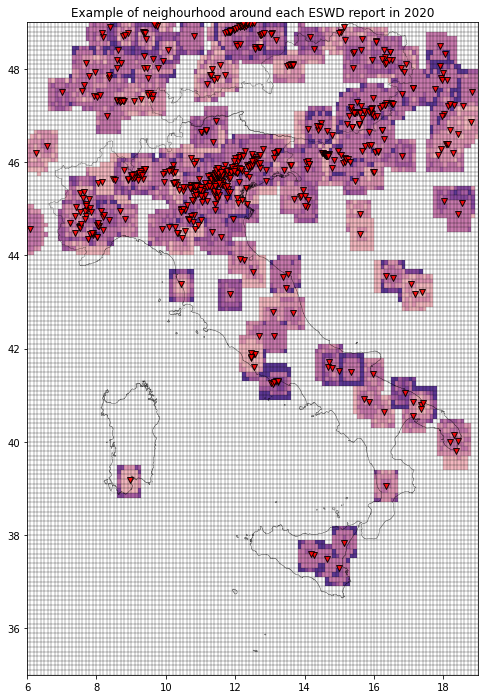

In [53]:
#EXAMPLE GEOGRAPHIC PLOT: SPHERA SLI parameter neighborhoods around every ESWD report

fig, ax = plt.subplots(figsize = (16,12))

if (x_lim != None) & (y_lim != None):     
    plt.xlim(x_lim)
    plt.ylim(y_lim)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.3, zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
    
sp_par='LI'
col_num = 3

#calculate colorcoding dependent from the chosen parameter
col_boxes = dgdf_sp_3ESWDh[0].box_id    

for ind in gdf_eswd.index:
    #print(ind)
    
        #2016: 
    #if (ind == 128) or (ind == 316) or (ind == 327) or (ind == 328) or (ind == 330):
        #2017: 
    #if (ind == 70) or (ind == 195) or (ind == 446) or (ind == 447):
        #2018: 
    #if (ind == 12):
    #    continue
        #2019
    #if (ind==280) or (ind==282):
    #    continue
        #2020
    if (ind==72) or (ind==75):
        continue
        
    color_ton, bins, colors = HF.HF_calc_color(dgdf_sp_3ESWDh[ind][sp_par], color=col_num)
    
    dgdf_sp_3ESWDh_nn[ind][[sp_par,'geometry']].plot(ax=ax, color=color_ton)

    pl.scatter(gdf_eswd.loc[ind].lon,gdf_eswd.loc[ind].lat,35,c='red',
                                marker="v",edgecolor='k',alpha=0.9,zorder=4)
    
plt.title('Example of neighourhood around each ESWD report in 2020')

In [18]:
"""
Read external file
"""
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2018_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2018 = pickle.load(file)

### 1.2.4) - Spatio-temporal aggregation of SPHERA predictors (extr max/min) around ESWD reports considering different subsamples:
All reports, small hail (<3cm), large hail(>=3cm), very-large hail(>=5cm)

In [8]:
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2016_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2016 = pickle.load(file)
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2017_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2017 = pickle.load(file)
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2018_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2018 = pickle.load(file)

In [9]:
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2019_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2019 = pickle.load(file)
#read dictionary to external file
with open(fold + 'data/SPHERA/sphera_indices_grid10km/eswdDays_3h_nn/SpInd_eswdDays_2020_Aggr3h-nn.txt', 'rb') as file:
     dgdf_sp_3ESWDh_nn_2020 = pickle.load(file)

In [10]:
#Define indices to be excluded for every year (i.e. SPHERA data missing or ESWD reports too close to border)
excl_ind_2016 = [128,316,327,328,330]
excl_ind_2017 = [70,195,446,447]
excl_ind_2018 = [12]
excl_ind_2019 = [280, 282]
excl_ind_2020 = [72, 75]

**- All ESWD reports**

In [11]:
gdf_sp_3ESWDh_nn_Aggr_2016 = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2016, excl_ind_2016)
gdf_sp_3ESWDh_nn_Aggr_2017 = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2017, excl_ind_2017)
gdf_sp_3ESWDh_nn_Aggr_2018 = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2018, excl_ind_2018)
gdf_sp_3ESWDh_nn_Aggr_2019 = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2019, excl_ind_2019)
gdf_sp_3ESWDh_nn_Aggr_2020 = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2020, excl_ind_2020)

In [12]:
#concat 3 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2018 = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016,
                                             gdf_sp_3ESWDh_nn_Aggr_2017,
                                             gdf_sp_3ESWDh_nn_Aggr_2018]).reset_index(drop=True)
gdf_sp_3ESWDh_nn_Aggr_2019_2020 = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2019,
                                             gdf_sp_3ESWDh_nn_Aggr_2020]).reset_index(drop=True)

#concat 5 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2020 = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016,
                                             gdf_sp_3ESWDh_nn_Aggr_2017,
                                             gdf_sp_3ESWDh_nn_Aggr_2018,
                                             gdf_sp_3ESWDh_nn_Aggr_2019,
                                             gdf_sp_3ESWDh_nn_Aggr_2020]).reset_index(drop=True)

**- Small hail:< 3cm**

In [13]:
#select eswd data over different years with hailsize <3cm:
eswd_2016_small = eswd_2016[eswd_2016['size']<3]
eswd_2017_small = eswd_2017[eswd_2017['size']<3]
eswd_2018_small = eswd_2018[eswd_2018['size']<3]
eswd_2019_small = eswd_2019[eswd_2019['size']<3]
eswd_2020_small = eswd_2020[eswd_2020['size']<3]

In [14]:
#select SPHERA subset presentin eswd event <3cm:
dgdf_sp_3ESWDh_nn_2016_small = {key: dgdf_sp_3ESWDh_nn_2016[key] for key in eswd_2016_small.index}
dgdf_sp_3ESWDh_nn_2017_small = {key: dgdf_sp_3ESWDh_nn_2017[key] for key in eswd_2017_small.index}
dgdf_sp_3ESWDh_nn_2018_small = {key: dgdf_sp_3ESWDh_nn_2018[key] for key in eswd_2018_small.index}
dgdf_sp_3ESWDh_nn_2019_small = {key: dgdf_sp_3ESWDh_nn_2019[key] for key in eswd_2019_small.index}
dgdf_sp_3ESWDh_nn_2020_small = {key: dgdf_sp_3ESWDh_nn_2020[key] for key in eswd_2020_small.index}

In [15]:
#SPHERA predictors spatio-temporal aggregation
gdf_sp_3ESWDh_nn_Aggr_2016_small = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2016_small, excl_ind_2016)
gdf_sp_3ESWDh_nn_Aggr_2017_small = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2017_small, excl_ind_2017)
gdf_sp_3ESWDh_nn_Aggr_2018_small = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2018_small, excl_ind_2018)
gdf_sp_3ESWDh_nn_Aggr_2019_small = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2019_small, excl_ind_2019)
gdf_sp_3ESWDh_nn_Aggr_2020_small = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2020_small, excl_ind_2020)

In [16]:
#concat 3 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2018_small = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_small]).reset_index(drop=True)
gdf_sp_3ESWDh_nn_Aggr_2019_2020_small = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2019_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_small]).reset_index(drop=True)

#concat 5 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2020_small = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2019_small,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_small]).reset_index(drop=True)

**- Large hail:>= 3cm**

In [17]:
#select eswd data over different years with hailsize >=3cm:
eswd_2016_large = eswd_2016[eswd_2016['size']>=3]
eswd_2017_large = eswd_2017[eswd_2017['size']>=3]
eswd_2018_large = eswd_2018[eswd_2018['size']>=3]
eswd_2019_large = eswd_2019[eswd_2019['size']>=3]
eswd_2020_large = eswd_2020[eswd_2020['size']>=3]

In [18]:
#select SPHERA subset presentin eswd event >=3cm:
dgdf_sp_3ESWDh_nn_2016_large = {key: dgdf_sp_3ESWDh_nn_2016[key] for key in eswd_2016_large.index}
dgdf_sp_3ESWDh_nn_2017_large = {key: dgdf_sp_3ESWDh_nn_2017[key] for key in eswd_2017_large.index}
dgdf_sp_3ESWDh_nn_2018_large = {key: dgdf_sp_3ESWDh_nn_2018[key] for key in eswd_2018_large.index}
dgdf_sp_3ESWDh_nn_2019_large = {key: dgdf_sp_3ESWDh_nn_2019[key] for key in eswd_2019_large.index}
dgdf_sp_3ESWDh_nn_2020_large = {key: dgdf_sp_3ESWDh_nn_2020[key] for key in eswd_2020_large.index}

In [19]:
#SPHERA predictors spatio-temporal aggregation
gdf_sp_3ESWDh_nn_Aggr_2016_large = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2016_large, excl_ind_2016)
gdf_sp_3ESWDh_nn_Aggr_2017_large = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2017_large, excl_ind_2017)
gdf_sp_3ESWDh_nn_Aggr_2018_large = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2018_large, excl_ind_2018)
gdf_sp_3ESWDh_nn_Aggr_2019_large = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2019_large, excl_ind_2019)
gdf_sp_3ESWDh_nn_Aggr_2020_large = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2020_large, excl_ind_2020)

In [20]:
#concat 3 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2018_large = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_large]).reset_index(drop=True)
gdf_sp_3ESWDh_nn_Aggr_2019_2020_large = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2019_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_large]).reset_index(drop=True)
#concat 5 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2020_large = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2019_large,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_large]).reset_index(drop=True)

**- Very large hail:>= 5cm**

In [21]:
#select eswd data over different years with hailsize >=5cm:
eswd_2016_Verylarge = eswd_2016[eswd_2016['size']>=5]
eswd_2017_Verylarge = eswd_2017[eswd_2017['size']>=5]
eswd_2018_Verylarge = eswd_2018[eswd_2018['size']>=5]
eswd_2019_Verylarge = eswd_2019[eswd_2019['size']>=5]
eswd_2020_Verylarge = eswd_2020[eswd_2020['size']>=5]

In [22]:
#select SPHERA subset presentin eswd event >=5cm:
dgdf_sp_3ESWDh_nn_2016_Verylarge = {key: dgdf_sp_3ESWDh_nn_2016[key] for key in eswd_2016_Verylarge.index}
dgdf_sp_3ESWDh_nn_2017_Verylarge = {key: dgdf_sp_3ESWDh_nn_2017[key] for key in eswd_2017_Verylarge.index}
dgdf_sp_3ESWDh_nn_2018_Verylarge = {key: dgdf_sp_3ESWDh_nn_2018[key] for key in eswd_2018_Verylarge.index}
dgdf_sp_3ESWDh_nn_2019_Verylarge = {key: dgdf_sp_3ESWDh_nn_2019[key] for key in eswd_2019_Verylarge.index}
dgdf_sp_3ESWDh_nn_2020_Verylarge = {key: dgdf_sp_3ESWDh_nn_2020[key] for key in eswd_2020_Verylarge.index}

In [23]:
#SPHERA predictors spatio-temporal aggregation
gdf_sp_3ESWDh_nn_Aggr_2016_Verylarge = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2016_Verylarge, excl_ind_2016)
gdf_sp_3ESWDh_nn_Aggr_2017_Verylarge = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2017_Verylarge, excl_ind_2017)
gdf_sp_3ESWDh_nn_Aggr_2018_Verylarge = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2018_Verylarge, excl_ind_2018)
gdf_sp_3ESWDh_nn_Aggr_2019_Verylarge = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2019_Verylarge, excl_ind_2019)
gdf_sp_3ESWDh_nn_Aggr_2020_Verylarge = HF.HF_rean_spatTempAggregation(dgdf_sp_3ESWDh_nn_2020_Verylarge, excl_ind_2020)

In [24]:
#concat 3 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2018_Verylarge = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_Verylarge]).reset_index(drop=True)
gdf_sp_3ESWDh_nn_Aggr_2019_2020_Verylarge = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2019_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_Verylarge]).reset_index(drop=True)

#concat 5 years together
gdf_sp_3ESWDh_nn_Aggr_2016_2020_Verylarge = pd.concat([gdf_sp_3ESWDh_nn_Aggr_2016_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2017_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2018_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2019_Verylarge,
                                             gdf_sp_3ESWDh_nn_Aggr_2020_Verylarge]).reset_index(drop=True)

### 1.2.5) - Cumulative distribution functions of the parameters considering full ESWD, small/large/verylarge hail separately:

In [41]:
#select parameter
sp_par = 'CAPE_MU'

In [42]:
#parameters for different proxies:
if sp_par == 'LI':
    un_meas = '[°C]'  #unit measure for colorbar label
    percent = 95
elif sp_par == 'Kindex':
    un_meas = '[°C]'
    percent = 5
elif sp_par == '%VV700':
    un_meas = '%'
    percent = 5
elif (sp_par == 'CAPE_MU') or (sp_par == 'CAPE_ML'):
    un_meas = '[J/kg]'
    percent = 5
elif sp_par == 'H0':
    un_meas = '[m]'
    percent = 95
elif sp_par == 'DLS':
    un_meas = '[m/s]'
    percent = 5

In [43]:
#select the years of the distr to be plotted
gdf_sp_3ESWDh_nn_Aggr = gdf_sp_3ESWDh_nn_Aggr_2016_2020
gdf_sp_3ESWDh_nn_Aggr_small = gdf_sp_3ESWDh_nn_Aggr_2016_2020_small
gdf_sp_3ESWDh_nn_Aggr_large = gdf_sp_3ESWDh_nn_Aggr_2016_2020_large
gdf_sp_3ESWDh_nn_Aggr_Verylarge = gdf_sp_3ESWDh_nn_Aggr_2016_2020_Verylarge

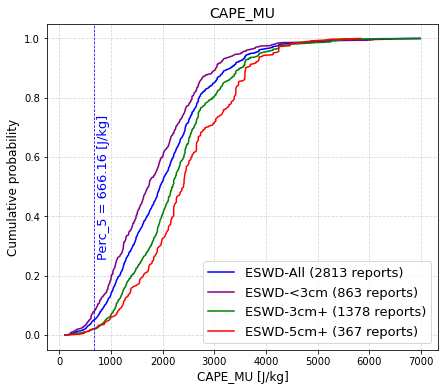

In [44]:
fig, ax = plt.subplots(figsize = (7,6))

data = gdf_sp_3ESWDh_nn_Aggr[sp_par]
data_large = gdf_sp_3ESWDh_nn_Aggr_large[sp_par]
data_Verylarge = gdf_sp_3ESWDh_nn_Aggr_Verylarge[sp_par]
data_small = gdf_sp_3ESWDh_nn_Aggr_small[sp_par]

#sort data
x = np.sort(data)
x_large = np.sort(data_large)
x_Verylarge = np.sort(data_Verylarge)
x_small = np.sort(data_small)

#calculate CDF values
y = 1. * np.arange(len(data)) / (len(data) - 1)
y_large = 1. * np.arange(len(data_large)) / (len(data_large) - 1)
y_Verylarge = 1. * np.arange(len(data_Verylarge)) / (len(data_Verylarge) - 1)
y_small = 1. * np.arange(len(data_small)) / (len(data_small) - 1)

#plot CDF
ax.plot(x, y, color='blue', label=f'ESWD-All ({len(gdf_sp_3ESWDh_nn_Aggr)} reports)')
ax.plot(x_small, y_small, color='purple', label=f'ESWD-<3cm ({len(gdf_sp_3ESWDh_nn_Aggr_small)} reports)')
ax.plot(x_large, y_large, color='green', label=f'ESWD-3cm+ ({len(gdf_sp_3ESWDh_nn_Aggr_large)} reports)')
ax.plot(x_Verylarge, y_Verylarge, color='red', label=f'ESWD-5cm+ ({len(gdf_sp_3ESWDh_nn_Aggr_Verylarge)} reports)')

ax.set_xlabel(f'{sp_par} ' + f'{un_meas}', fontsize=12)
ax.set_ylabel('Cumulative probability', fontsize=12)
ax.set_title(f'{sp_par}', fontsize=14);

plt.axvline(x=np.percentile(x,percent), lw=0.75, linestyle='--', color='blue')
#plt.axvline(x=np.percentile(x_large,percent), lw=0.75, linestyle='--', color='green')
#plt.axvline(x=np.percentile(x_Verylarge,percent), lw=0.75, linestyle='--', color='red')
#plt.axvline(x=np.percentile(x_small,percent), lw=0.75, linestyle='--', color='purple')

plt.text(np.percentile(x,percent)*(1+.08), .5, f"Perc_{percent} = {np.percentile(x,percent):.5} {un_meas}", 
         rotation=90, verticalalignment='center', color='blue', fontsize=13)
#plt.text(np.percentile(x_large,percent)*(1+0.15), .5, f"Perc_{percent} = {np.percentile(x_3cm,percent):.5} {un_meas}", 
#         rotation=90, verticalalignment='center', color='green', fontsize=13)
#plt.text(np.percentile(x_Verylarge,percent)*(1+0.05), .5, f"Perc_{percent} = {np.percentile(x_5cm,percent):.5} {un_meas}", 
#         rotation=90, verticalalignment='center', color='red', fontsize=13)
#plt.text(np.percentile(x_small,percent)*(1-0.7), .5, f"Perc_{percent} = {np.percentile(x_small,percent):.5} {un_meas}", 
#         rotation=90, verticalalignment='center', color='purple', fontsize=13)

plt.grid(ls='--', alpha=0.5)
plt.legend(loc='best', fontsize=13)